In [1]:
import pandas as pd
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
passenger = pd.read_csv("C:\\Users\\HP\\Data Science\\Datasets\\AirPassengers.csv")

In [3]:
passenger.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
passenger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month          144 non-null object
#Passengers    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [5]:
passenger["Month"] = pd.to_datetime(passenger["Month"],infer_datetime_format=True)

In [6]:
passenger = passenger.set_index("Month")

In [7]:
passenger.tail()

,#Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


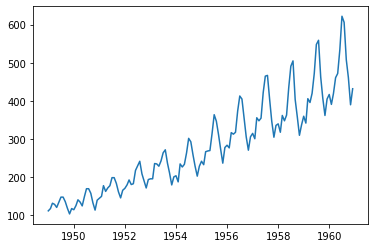

In [8]:
plt.plot(passenger)

It is clearly evident that there is an overall increasing trend in the data along with some seasonal variations

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    dftest = adfuller(timeseries["#Passengers"], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


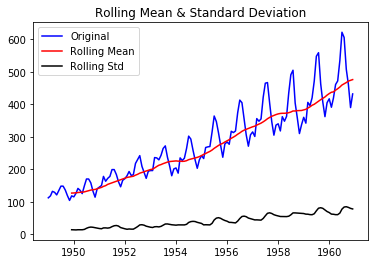

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [10]:
test_stationarity(passenger)

- Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series.
- Null Hypothesis : Data is not stationary
- Since the test statistic is way more than the critical values, we accept the null hypothesis saying that the data is not stationary.


#### Making Time Series data Stationary
- Components :
    - Trend
    - Seasonality

In [11]:
passenger_log = np.log(passenger)

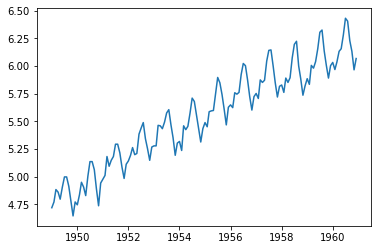

In [12]:
plt.plot(passenger_log)

In [15]:
passenger.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


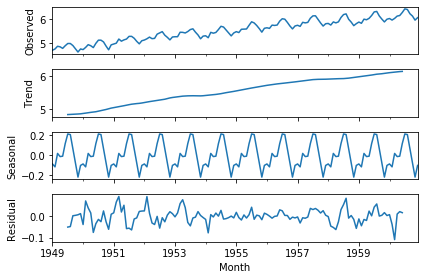

In [13]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(passenger_log,model ="additive")
fig = decomposition.plot()
plt.show()

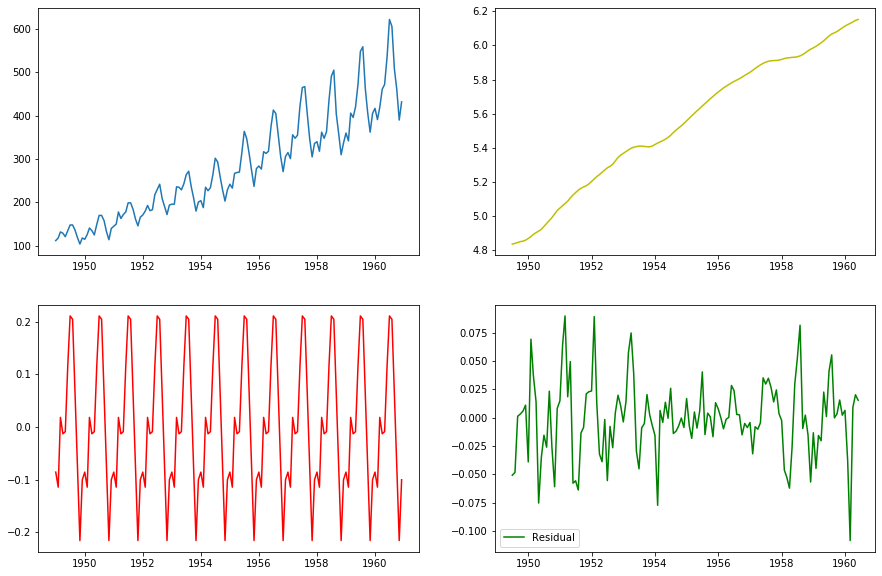

In [41]:
plt.figure(figsize=(15,10))
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

plt.subplot(221)
plt.plot(passenger,label="Original")
plt.subplot(222)
plt.plot(trend,label="Trend",color='y')
plt.subplot(223)
plt.plot(seasonality,label="Seasonality",color='r')
plt.subplot(224)
plt.plot(residual,label="Residual",color='g')

plt.legend()
plt.show()


##### Moving Average

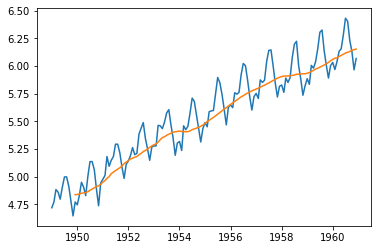

In [15]:
rollingmean = passenger_log.rolling(window=12).mean()
plt.plot(passenger_log)
plt.plot(rollingmean)

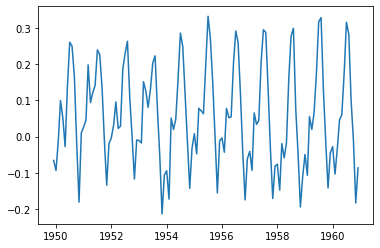

In [17]:
passenger_log_rollingmean_diff = passenger_log - rollingmean
plt.plot(passenger_log_rollingmean_diff)

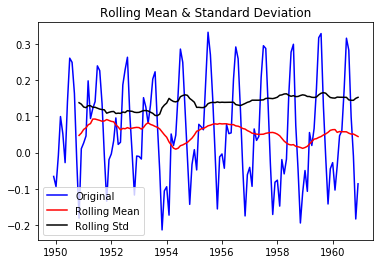

Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [18]:
passenger_log_rollingmean_diff.dropna(inplace=True)
test_stationarity(passenger_log_rollingmean_diff)

#### Exponentially moving weighted average

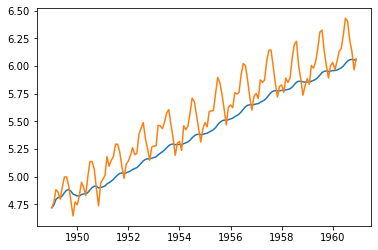

In [19]:
weighted_avg = passenger_log.ewm(halflife=12).mean()
plt.plot(weighted_avg)
plt.plot(passenger_log)

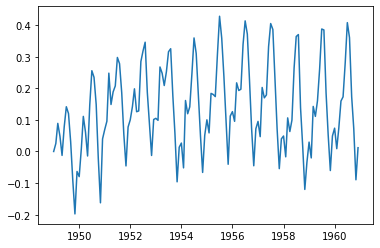

In [20]:
passenger_log_weighted_avg = passenger_log - weighted_avg
plt.plot(passenger_log_weighted_avg)

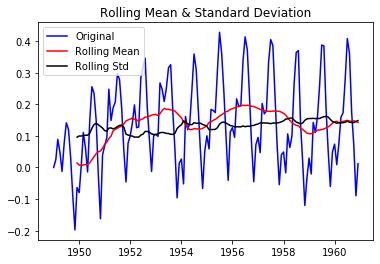

Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [21]:
test_stationarity(passenger_log_weighted_avg)

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality
- Differencing – taking the difference with a particular time lag
- Decomposition – modeling both trend and seasonality and removing them from the model.


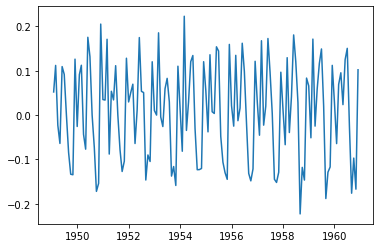

In [22]:
passenger_shift = passenger_log - passenger_log.shift()
plt.plot(passenger_shift)

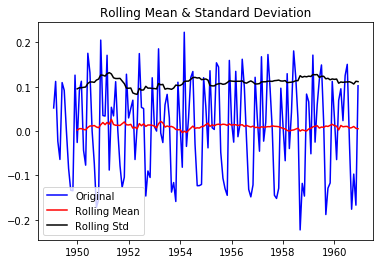

Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [23]:
passenger_shift.dropna(inplace=True)
test_stationarity(passenger_shift)

We can see that the mean and std variations have small variations with time and hence we will go with second order differenciation

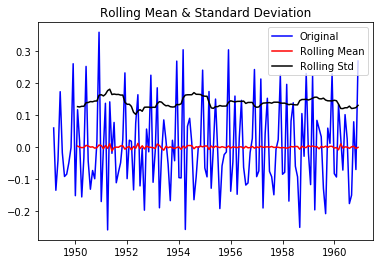

Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


In [24]:
passenger_shift2 = passenger_shift - passenger_shift.shift()
passenger_shift2.dropna(inplace=True)
test_stationarity(passenger_shift2)

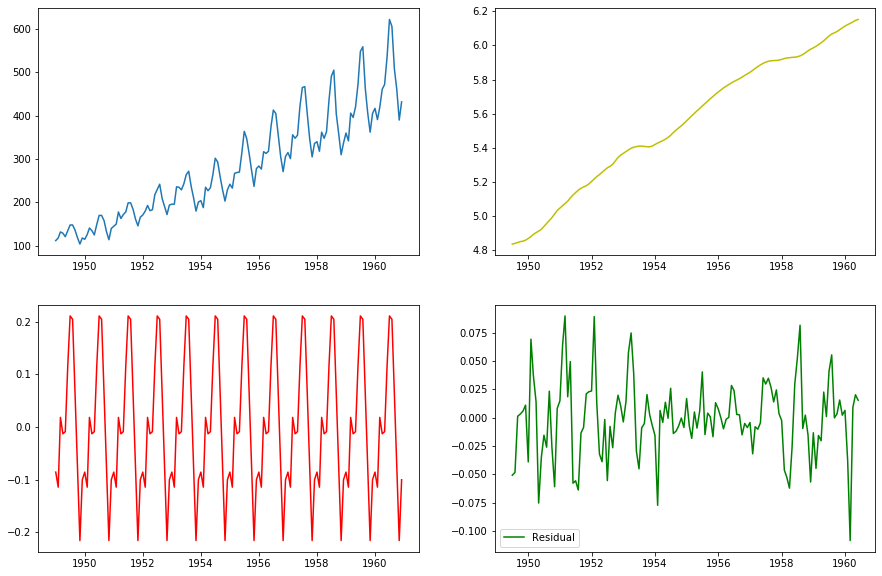

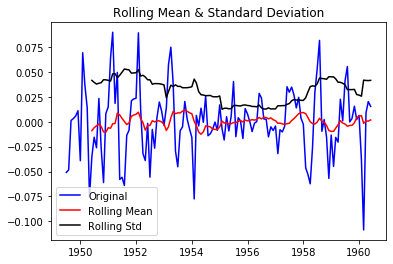

Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [29]:
residual = decomposition.resid
residual.dropna(inplace=True)
test_stationarity(residual)

In [43]:
import warnings
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [47]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(passenger,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1887.2251456185438
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:1315.9211929474204
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:1156.2914901508536
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:1118.6259190717344
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1107.2562043238904
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:1109.2437994445113
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1033.6172166729789
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:1846.07893775716
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:1567.9916312315604
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:1196.998361439982
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:1072.1382984044358
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1071.0026810194986
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:1049.5801416332706
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:1059.5112223290416
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:985.3346478032175
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:1405.000661294967
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1194.7130010979695
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AI

In [63]:
mod = sm.tsa.statespace.SARIMAX(passenger,
                                order=(0, 1, 1),
                                seasonal_order=(1,1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3198      0.074     -4.299      0.000      -0.466      -0.174
ar.S.L12      -0.1526      0.093     -1.645      0.100      -0.334       0.029
sigma2       143.5585     17.846      8.044      0.000     108.581     178.536


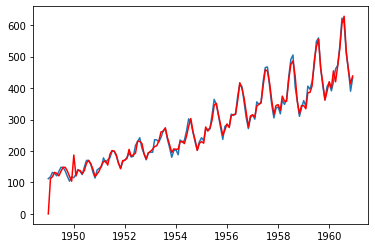

In [64]:
plt.plot(passenger)
plt.plot(results.fittedvalues, color='red')

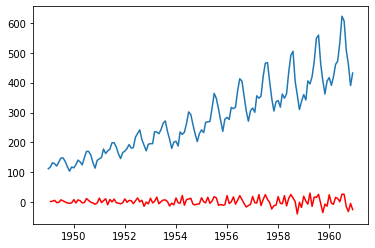

In [61]:
from statsmodels.tsa.arima_model import ARIMA
arima_model = ARIMA(passenger, order=(0, 1, 1))  
results_ARIMA = arima_model.fit()  
plt.plot(passenger)
plt.plot(results_ARIMA.fittedvalues, color='red')

### Auto Arima

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
train = passenger[:int(0.7*(len(passenger)))]
valid = passenger[int(0.7*(len(passenger))):]

In [68]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(0, 1, 1),
                                seasonal_order=(1,1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2708      0.107     -2.533      0.011      -0.480      -0.061
ar.S.L12      -0.2264      0.098     -2.319      0.020      -0.418      -0.035
sigma2        96.4907     16.774      5.752      0.000      63.614     129.367


In [70]:
forecast = mod.predict()

TypeError: predict() missing 1 required positional argument: 'params'

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 1, 12); AIC=646.567, BIC=666.294, Fit time=1.636 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=652.680, BIC=657.612, Fit time=0.015 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=645.940, BIC=655.803, Fit time=0.283 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=646.447, BIC=656.311, Fit time=0.309 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=647.792, BIC=655.190, Fit time=0.069 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=647.914, BIC=660.244, Fit time=0.849 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=647.927, BIC=660.257, Fit time=0.418 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=646.268, BIC=661.064, Fit time=3.234 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=649.280, BIC=656.678, Fit time=0.168 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 

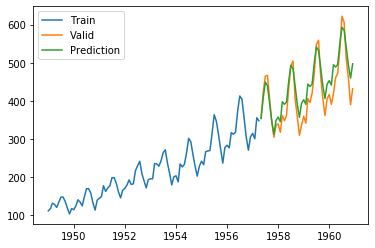

Optimized value for order: (1, 1, 0)
Optimized value for order: (1, 1, 0, 12)


In [67]:
from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True,seasonal=True,stepwise=True,
                    m=12,n_fits=30)
model.fit(train)

forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.legend()
plt.show()
print("Optimized value for order: {}".format(model.order))
print("Optimized value for order: {}".format(model.seasonal_order))

In [39]:
from math import sqrt
from sklearn.metrics import mean_squared_error,r2_score

rms = sqrt(mean_squared_error(valid,forecast))
print("Root mean square error : {}".format(rms))
print("R^2 Score : {}".format(r2_score(valid,forecast)))


Root mean square error : 34.93632031142575
R^2 Score : 0.7911476372564519
